In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

import scipy.constants as constants
import scipy.special as special

from qutip import *

#%matplotlib ipympl

# Max Fock State
N = 100

options = Options()
options.num_cpus = 5
options.nsteps = 10000

### Ideal Cubic Phase Gate

An ideal cubic phase gate takes the form 
$$
U_{\text{cube}} \equiv \exp{i \chi \hat{X}^3}
$$
where $\chi$ is the squeezing parameter.

We want to first study the Wigner function of the ideal cubic phase gate that we aspire to achieve.

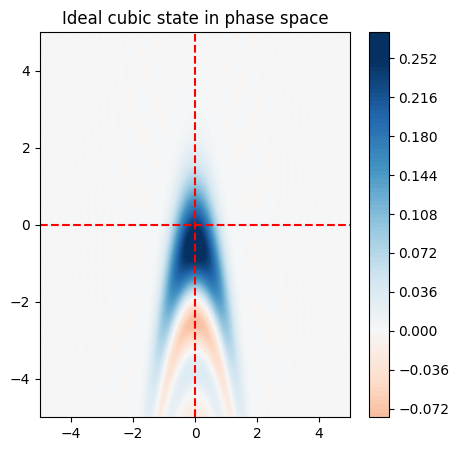

In [2]:
a = destroy(N)
x = ( 1/np.sqrt(2) ) * (a + a.dag())

chi = 0.6 # This is not the squeezing parameter, but just a convenient factor for simulation purposes.

H =  chi * x**3

psi0 = basis(N)  # Initialise in Fock |0> state.
t = [0.0, 1.0]

output = mesolve(H = H, rho0 = psi0, tlist = t, e_ops = [a.dag() * a], options = options)
n_c = output.expect[0]

# ---------- Plot Wigner Function at the end of the evolution ----------#
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

output = mesolve(H = H, rho0 = psi0, tlist = t, options = options)
rho = output.states[-1]

xvec = np.linspace(-5, 5, 200)
W = wigner(rho, xvec, xvec)

axes.vlines(0, ymin = -5, ymax = 5, colors = 'r', linestyles = 'dashed')
axes.hlines(0, xmin = -5, xmax = 5, colors = 'r', linestyles = 'dashed')
im = axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes.set_title("Ideal cubic state in phase space")
plt.colorbar(im)

### Kimin's Pulse Sequence

The paper proposes the simulation of an ideal cubic phase gate via the following decomposition:
$$
    U_\text{cube} \approx U = \exp(i \gamma \hat{X}) \prod_{j=1}^N \bigg[\exp[i \phi_j \hat{\sigma}_y] \exp[it\hat{\sigma}_z \hat{X}] \bigg] \exp[i \phi_0 \hat{\sigma}_y]
$$
With better accuracies possible with a larger number of pulses, N.

In [3]:
solution = [-0.353282, 0.902028, -0.518804, 
            -0.447977, 0.447404, 0.231963,
            -0.307409, -0.191352, 0.354135,
            0.141061, -0.544457, -0.310069,
            0.685625, 0.623302, -0.144266,
            -0.808851, -0.102101, -0.682909,
            1.021610, 0.534188, -0.54781]

def clean_plot(n_c, n_a, rho, tlist):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    # ---------- Plot Wigner Function at the end of the evolution ----------#
    xvec = np.linspace(-5, 5, 200)
    W = wigner(rho, xvec, xvec)

    axes[0].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
    axes[0].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    im = axes[0].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    axes[0].set_title("Final State after N = 20 Pulses")
    plt.colorbar(im)

    # ---------- Plot atom & phonon population at end of evolution ----------#
    axes[1].plot(tlist, n_a, 'r-', label="Atom state")
    axes[1].plot(tlist, n_c, 'b-', label="Phonon state")
    axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[1].legend()
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Excitation probability")
    axes[1].set_title("Evolution of Spin")

In [4]:
a = tensor(qeye(2), destroy(N))
x = tensor(qeye(2), position(N))

sY = tensor(sigmay(), qeye(N))
sZ = tensor(sigmaz(), qeye(N))
sM = tensor(destroy(2), qeye(N))

psi0 = tensor(basis(2, 0), basis(N, 0))

In [5]:
def pulse(initial_state, angle):
    t_Spin = 1.0 # Spin interaction duration
    t_JC = 0.5 # Rabi interaction duration
    
    H1 = - angle * sY # Part 1
    H2 = - sZ * x    # Part 2

    t1 = np.linspace(0.0, t_Spin, 100)
    t2 = np.linspace(0.0, t_JC, 100)

    output = mesolve(H = H1, rho0 = initial_state, tlist = t1, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon = output.expect[0]
    n_atom_impt = output.expect[1]
    rho1 = output.states[-1]

    output = mesolve(H = H2, rho0 = rho1, tlist = t2, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon_impt = output.expect[0]
    n_atom = output.expect[1]
    rho2 = output.states[-1]
    
    return rho2, n_atom_impt, n_phonon_impt

In [6]:
psi = tensor(basis(2, 0), basis(N, 0))

states = [[] for i in range(len(solution))]
pop_atom = [[] for i in range(len(solution))]
pop_phonon = [[] for i in range(len(solution))]

for i in range(len(solution)):
    psi, n_atom, n_phonon = pulse(psi, solution[i])
    states[i] = psi
    pop_atom[i] = n_atom
    pop_phonon[i] = n_phonon

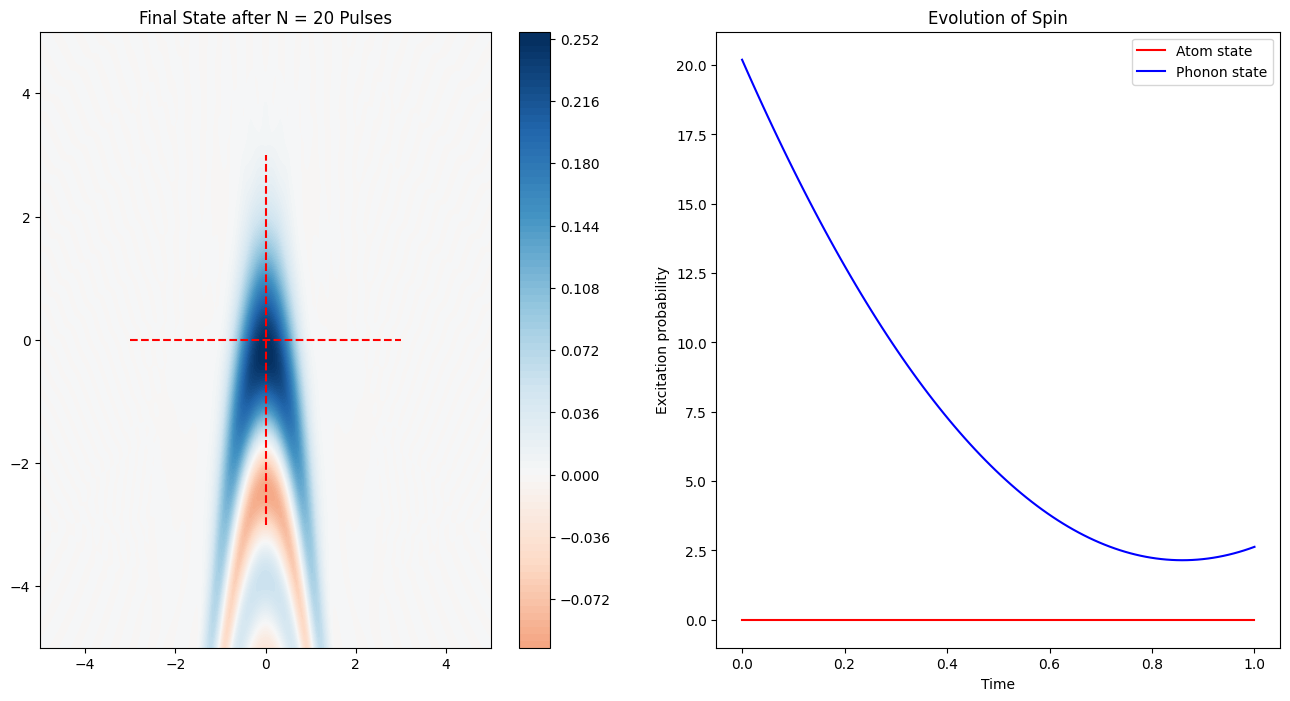

In [7]:
rho = states[-1]

H = 7 * x
t = np.linspace(0.0, 1.0, 100)

output = mesolve(H = H, rho0 = rho, tlist = t, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
n_phonon = output.expect[0]
n_atom = output.expect[1]
rho1 = output.states[-1]

clean_plot(n_phonon, n_atom, rho1, t)